# Notebook 4 – Registry Delta Features and Delta-Only Model

This notebook starts from a version-level table `delta_live` built in the
previous notebook and performs the following steps:

1. **Online feature extraction (registries only)**
   - Query PyPI and npm registries to obtain static package metadata:
     - Compressed size of the published artifact where available.
     - Uncompressed size and file count where available.
     - Basic distribution attributes (filename, URL, packagetype).

2. **Derived static features (per version)**
   - Unified package size and version-to-version size deltas.
   - Density / entropy-like proxies based on bytes per file.

3. **Delta feature construction (registry-derived)**
   - For selected static registry attributes, compute **deltas vs previous version**:
     - `delta_<feature>` and `ratio_<feature>`.
   - Combine these with existing delta features from the previous notebook.

4. **Delta-only modeling**
   - Train a balanced logistic regression model **only on delta features**:
     - Existing delta features (`delta_cols` from the previous notebook).
     - New registry delta features (`delta_*` / `ratio_*`).
   - Evaluate performance (ROC AUC and classification metrics).
   - Use coefficients for feature importance and optionally train a compact model
     using a subset of high-impact delta features.


In [1]:
# Cell 2 – Imports, configuration, and helpers

from pathlib import Path
from typing import Optional, Dict, Any, Tuple

import requests
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report,
)

# Base directories and expected locations for data
DATA_DIR = Path("data")
PROCESSED_DIR = DATA_DIR / "processed"

# HTTP session for registry calls
HTTP_TIMEOUT = 15  # seconds
SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "project4900-registry-delta/1.0"})

# Simple caches to avoid repeated queries for the same project/version
pypi_cache: Dict[Tuple[str, str], Optional[Dict[str, Any]]] = {}
npm_cache: Dict[Tuple[str, str], Optional[Dict[str, Any]]] = {}


In [2]:
# Cell 3 – Load labels and delta_live from memory or disk

# Base metadata paths
META_DIR = Path("../data/meta")
LABELS_VERSION_PATH = META_DIR / "labels_version.csv"
LABELS_PACKAGE_PATH = META_DIR / "labels_package.csv"

# Primary path for live version-delta features
DELTA_LIVE_PATH = META_DIR / "version_delta_features_live.csv"

# Fallback paths (e.g., outputs from previous notebooks)
DELTA_LIVE_PATHS = [
    DELTA_LIVE_PATH,  # preferred CSV
    PROCESSED_DIR / "version_diff_live" / "delta_live.parquet",
    PROCESSED_DIR / "delta_live.parquet",
]

if "delta_live" in globals():
    print("[INFO] Using existing delta_live DataFrame from previous notebook.")
else:
    loaded = False
    for path in DELTA_LIVE_PATHS:
        if not path.exists():
            continue
        print(f"[INFO] Loading delta_live from {path}")
        if path.suffix == ".parquet":
            delta_live = pd.read_parquet(path)
        else:
            delta_live = pd.read_csv(path)
        loaded = True
        break

    if not loaded:
        raise FileNotFoundError(
            "delta_live not found. Ensure version_delta_features_live.csv "
            "or one of the parquet outputs exists, or update DELTA_LIVE_PATHS."
        )

print("delta_live shape:", delta_live.shape)
print("Sample columns:", list(delta_live.columns)[:25], "...")
delta_live.head()


[INFO] Loading delta_live from ..\data\meta\version_delta_features_live.csv
delta_live shape: (155, 18)
Sample columns: ['ecosystem', 'package_name', 'prev_version', 'version', 'y_malicious', 'delta_num_requires_dist', 'delta_summary_len', 'delta_description_len', 'delta_num_classifiers', 'delta_has_author', 'delta_has_license', 'delta_num_dependencies', 'delta_num_dev_dependencies', 'delta_num_scripts', 'delta_num_keywords', 'delta_version_len', 'delta_version_num_dots', 'delta_version_has_prerelease'] ...


,ecosystem,package_name,prev_version,version,y_malicious,delta_num_requires_dist,delta_summary_len,delta_description_len,delta_num_classifiers,delta_has_author,delta_has_license,delta_num_dependencies,delta_num_dev_dependencies,delta_num_scripts,delta_num_keywords,delta_version_len,delta_version_num_dots,delta_version_has_prerelease
0,npm,@accordproject/concerto-analysis,3.24.0,3.24.1-20250827130031,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,1.0
1,npm,@accordproject/concerto-linter,3.24.0,3.24.1-20250827130031,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,1.0
2,npm,@accordproject/concerto-linter-default-ruleset,3.24.0,3.24.1-20250827130031,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,1.0
3,npm,@accordproject/concerto-metamodel,3.12.4-20250801113513,3.12.5-20250801113804,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,npm,@accordproject/concerto-types,3.24.0,3.24.1-20250827130031,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,1.0


In [3]:
# Cell 3b – Resolve core column names used in delta_live

print("delta_live columns:", list(delta_live.columns))

PKG_COL_CANDIDATES = ["name", "package_name", "project", "pkg", "pkg_name"]
VER_COL_CANDIDATES = ["version", "version_str", "ver"]
ECO_COL_CANDIDATES = ["ecosystem", "eco", "source", "manager"]

def pick_col(candidates, desc):
    for c in candidates:
        if c in delta_live.columns:
            print(f"[INFO] Using column '{c}' as {desc}")
            return c
    raise KeyError(
        f"Could not find any of {candidates} for {desc} in delta_live.columns"
    )

PKG_COL = pick_col(PKG_COL_CANDIDATES, "package name")
VER_COL = pick_col(VER_COL_CANDIDATES, "version")
ECO_COL = pick_col(ECO_COL_CANDIDATES, "ecosystem")

# Normalize ecosystem labels to lowercase strings
delta_live[ECO_COL] = delta_live[ECO_COL].astype(str).str.lower().str.strip()

print("\nEcosystem value counts:")
print(delta_live[ECO_COL].value_counts())


delta_live columns: ['ecosystem', 'package_name', 'prev_version', 'version', 'y_malicious', 'delta_num_requires_dist', 'delta_summary_len', 'delta_description_len', 'delta_num_classifiers', 'delta_has_author', 'delta_has_license', 'delta_num_dependencies', 'delta_num_dev_dependencies', 'delta_num_scripts', 'delta_num_keywords', 'delta_version_len', 'delta_version_num_dots', 'delta_version_has_prerelease']
[INFO] Using column 'package_name' as package name
[INFO] Using column 'version' as version
[INFO] Using column 'ecosystem' as ecosystem

Ecosystem value counts:
ecosystem
npm    155
Name: count, dtype: int64


## 1. Static registry metadata

Each row in `delta_live` represents a version of a package
(`ecosystem`, `PKG_COL`, `VER_COL`), optionally linked to a previous version
(`prev_version`).

This section augments each version with static metadata from the official
registries only, without any threat-intelligence or sandbox APIs.

### PyPI

From `/pypi/<project>/<version>/json`:

- Compressed size of a primary distribution file.
- Basic file metadata such as filename, URL, and packagetype.

Derived fields:

- `pypi_size_bytes`
- `pypi_packagetype`
- `pypi_filename`
- `pypi_url`

### npm

From `https://registry.npmjs.org/<name>/<version>`:

- Tarball URL and integrity fields.
- Uncompressed size and file count (if available).

Derived fields:

- `npm_tarball_url`
- `npm_shasum`
- `npm_integrity`
- `npm_unpacked_size_bytes`
- `npm_file_count`

These registry-derived attributes form the core **static metadata** group, which
is then transformed into **delta features** for modeling.


In [4]:
# Cell 5 – PyPI metadata fetch

def fetch_pypi_release(name: str, version: str) -> Optional[Dict[str, Any]]:
    """
    Fetch PyPI metadata for a given project/version from /pypi/<project>/<version>/json.
    Returns a dict with derived fields or None on failure.
    """
    key = (name, version)
    if key in pypi_cache:
        return pypi_cache[key]

    url = f"https://pypi.org/pypi/{name}/{version}/json"
    try:
        resp = SESSION.get(url, timeout=HTTP_TIMEOUT)
        if resp.status_code != 200:
            pypi_cache[key] = None
            return None
        data = resp.json()
    except Exception as e:
        print(f"[WARN] PyPI request failed for {name} {version}: {e}")
        pypi_cache[key] = None
        return None

    urls = data.get("urls") or []
    if not urls:
        pypi_cache[key] = None
        return None

    # Prefer wheel, fallback to sdist, else first
    preferred = None
    for f in urls:
        if f.get("packagetype") == "bdist_wheel":
            preferred = f
            break
    if preferred is None:
        for f in urls:
            if f.get("packagetype") == "sdist":
                preferred = f
                break
    if preferred is None:
        preferred = urls[0]

    result = {
        "pypi_size_bytes": preferred.get("size"),
        "pypi_packagetype": preferred.get("packagetype"),
        "pypi_filename": preferred.get("filename"),
        "pypi_url": preferred.get("url"),
    }
    pypi_cache[key] = result
    return result


# Quick test on a few PyPI rows (if any)
sample_pypi = delta_live[delta_live[ECO_COL] == "pypi"].head(3)
print(f"[INFO] Sample PyPI rows found: {len(sample_pypi)}")
for _, row in sample_pypi.iterrows():
    info = fetch_pypi_release(row[PKG_COL], row[VER_COL])
    print(row[PKG_COL], row[VER_COL], "->", info)


[INFO] Sample PyPI rows found: 0


In [5]:
# Cell 6 – npm metadata fetch

def fetch_npm_version(name: str, version: str) -> Optional[Dict[str, Any]]:
    """
    Fetch npm registry metadata for a given package version from
    https://registry.npmjs.org/<name>/<version>.
    Returns a dict with derived fields or None on failure.
    """
    key = (name, version)
    if key in npm_cache:
        return npm_cache[key]

    url = f"https://registry.npmjs.org/{name}/{version}"
    try:
        resp = SESSION.get(url, timeout=HTTP_TIMEOUT)
        if resp.status_code != 200:
            npm_cache[key] = None
            return None
        data = resp.json()
    except Exception as e:
        print(f"[WARN] npm request failed for {name}@{version}: {e}")
        npm_cache[key] = None
        return None

    dist = data.get("dist") or {}
    result = {
        "npm_tarball_url": dist.get("tarball"),
        "npm_shasum": dist.get("shasum"),
        "npm_integrity": dist.get("integrity"),
        "npm_unpacked_size_bytes": dist.get("unpackedSize"),
        "npm_file_count": dist.get("fileCount"),
    }
    npm_cache[key] = result
    return result


# Quick test on a few npm rows (if any)
sample_npm = delta_live[delta_live[ECO_COL] == "npm"].head(3)
print(f"[INFO] Sample npm rows found: {len(sample_npm)}")
for _, row in sample_npm.iterrows():
    info = fetch_npm_version(row[PKG_COL], row[VER_COL])
    print(row[PKG_COL], row[VER_COL], "->", info)


[INFO] Sample npm rows found: 3
@accordproject/concerto-analysis 3.24.1-20250827130031 -> {'npm_tarball_url': 'https://registry.npmjs.org/@accordproject/concerto-analysis/-/concerto-analysis-3.24.1-20250827130031.tgz', 'npm_shasum': '4226c5234d18b36b61a40a78112454d63516770a', 'npm_integrity': 'sha512-Tbkv+SiXyO2NXBRjpbPCGfFecr3Rm5gAOuM2qfe8ekJ9xb8lai4/n4CUlP9pWLJ2Gs29iQ7NG1WjbHvqVyd6QQ==', 'npm_unpacked_size_bytes': 147802, 'npm_file_count': 61}
@accordproject/concerto-linter 3.24.1-20250827130031 -> {'npm_tarball_url': 'https://registry.npmjs.org/@accordproject/concerto-linter/-/concerto-linter-3.24.1-20250827130031.tgz', 'npm_shasum': 'fa3fb54cfeb160ac1987c7fff0b0bef9cb7f9efc', 'npm_integrity': 'sha512-LbQXLuV/Dx+hj6hFxGOU3jLRQEsMA0XT2jtdcQhQwiW4RvKBH7zzWGDhf1AuRu4l/k2cjw1WYZ0JjccpTy2YxA==', 'npm_unpacked_size_bytes': 122945, 'npm_file_count': 64}
@accordproject/concerto-linter-default-ruleset 3.24.1-20250827130031 -> {'npm_tarball_url': 'https://registry.npmjs.org/@accordproject/con

In [6]:
# Cell 7 – Apply registry enrichment to all versions

def enrich_with_registry(row: pd.Series) -> Dict[str, Any]:
    eco = str(row[ECO_COL]).lower().strip()
    name = row[PKG_COL]
    version = row[VER_COL]

    if eco == "pypi":
        meta = fetch_pypi_release(name, version) or {}
    elif eco == "npm":
        meta = fetch_npm_version(name, version) or {}
    else:
        meta = {}

    return meta


registry_records = []

print("[INFO] Enriching with PyPI/npm registry metadata...")
for _, r in tqdm(delta_live.iterrows(), total=len(delta_live)):
    registry_records.append(enrich_with_registry(r))

registry_df = pd.DataFrame(registry_records, index=delta_live.index)

print("registry_df shape:", registry_df.shape)
registry_df.head()


[INFO] Enriching with PyPI/npm registry metadata...


  0%|          | 0/155 [00:00<?, ?it/s]

registry_df shape: (155, 5)


,npm_tarball_url,npm_shasum,npm_integrity,npm_unpacked_size_bytes,npm_file_count
0,https://registry.npmjs.org/@accordproject/conc...,4226c5234d18b36b61a40a78112454d63516770a,sha512-Tbkv+SiXyO2NXBRjpbPCGfFecr3Rm5gAOuM2qfe...,147802,61
1,https://registry.npmjs.org/@accordproject/conc...,fa3fb54cfeb160ac1987c7fff0b0bef9cb7f9efc,sha512-LbQXLuV/Dx+hj6hFxGOU3jLRQEsMA0XT2jtdcQh...,122945,64
2,https://registry.npmjs.org/@accordproject/conc...,992c36a098d3d93ac16988ebdc8a073af7bd4d6e,sha512-yiU5NDLGVN941TuWvZNpeDu9MKfpJEFddEct5V8...,98412,83
3,https://registry.npmjs.org/@accordproject/conc...,e7599919e99cf1646aec23c13acbd4787109ac7d,sha512-jUpQgoRxj0iI14wBiFMkrbPnb4UvLbgLEo0NUvb...,193491,38
4,https://registry.npmjs.org/@accordproject/conc...,863dd662c8179210bb59d4fdaab402c0fa0eae6a,sha512-FHaOKoR6qnI7QRtsrMDfLRFx28z5Pmu1o/wVSWo...,55176,31


In [7]:
# Cell 8 – Combine base delta_live and registry metadata

enriched = pd.concat(
    [
        delta_live.reset_index(drop=True),
        registry_df.reset_index(drop=True),
    ],
    axis=1,
)

print("enriched shape after registry merge:", enriched.shape)
enriched.head()


enriched shape after registry merge: (155, 23)


,ecosystem,package_name,prev_version,version,y_malicious,delta_num_requires_dist,delta_summary_len,delta_description_len,delta_num_classifiers,delta_has_author,...,delta_num_scripts,delta_num_keywords,delta_version_len,delta_version_num_dots,delta_version_has_prerelease,npm_tarball_url,npm_shasum,npm_integrity,npm_unpacked_size_bytes,npm_file_count
0,npm,@accordproject/concerto-analysis,3.24.0,3.24.1-20250827130031,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.0,0.0,1.0,https://registry.npmjs.org/@accordproject/conc...,4226c5234d18b36b61a40a78112454d63516770a,sha512-Tbkv+SiXyO2NXBRjpbPCGfFecr3Rm5gAOuM2qfe...,147802,61
1,npm,@accordproject/concerto-linter,3.24.0,3.24.1-20250827130031,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.0,0.0,1.0,https://registry.npmjs.org/@accordproject/conc...,fa3fb54cfeb160ac1987c7fff0b0bef9cb7f9efc,sha512-LbQXLuV/Dx+hj6hFxGOU3jLRQEsMA0XT2jtdcQh...,122945,64
2,npm,@accordproject/concerto-linter-default-ruleset,3.24.0,3.24.1-20250827130031,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.0,0.0,1.0,https://registry.npmjs.org/@accordproject/conc...,992c36a098d3d93ac16988ebdc8a073af7bd4d6e,sha512-yiU5NDLGVN941TuWvZNpeDu9MKfpJEFddEct5V8...,98412,83
3,npm,@accordproject/concerto-metamodel,3.12.4-20250801113513,3.12.5-20250801113804,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,https://registry.npmjs.org/@accordproject/conc...,e7599919e99cf1646aec23c13acbd4787109ac7d,sha512-jUpQgoRxj0iI14wBiFMkrbPnb4UvLbgLEo0NUvb...,193491,38
4,npm,@accordproject/concerto-types,3.24.0,3.24.1-20250827130031,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.0,0.0,1.0,https://registry.npmjs.org/@accordproject/conc...,863dd662c8179210bb59d4fdaab402c0fa0eae6a,sha512-FHaOKoR6qnI7QRtsrMDfLRFx28z5Pmu1o/wVSWo...,55176,31


## 2. Derived static and entropy-like features

Although the model will be trained **only on delta features**, this section
first constructs per-version static features and then transforms them into
deltas.

### Unified size and package-scale features

- `static_size_compressed_bytes`
  - For PyPI: compressed size from `pypi_size_bytes`.
  - For npm: not directly available from the registry (left as missing).
- `static_size_uncompressed_bytes`
  - For npm: `npm_unpacked_size_bytes` when available.
- `static_pkg_size_bytes`
  - A unified “size of package” feature combining the best available size:
    - Prefers uncompressed size (npm).
    - Falls back to compressed size (PyPI) when uncompressed size is missing.

### Version-delta size features (core)

- `static_size_prev_bytes`
  - Package size for the previous version (unified size).
- `static_size_delta_vs_prev`
  - Difference between current and previous unified size.
- `static_size_ratio_vs_prev`
  - Ratio of current unified size to previous unified size.

These are already size **deltas** for the unified package size and will be
part of the delta feature set.

### Density / entropy-like indicators

- `entropy_ratio_size`
  - Defined as bytes-per-file where file counts are available:
    - `static_pkg_size_bytes / npm_file_count`.
- `entropy_indicator`
  - Binary indicator derived from `entropy_ratio_size` using a threshold.

In the next step, selected static attributes (including these density features)
are turned into explicit delta features relative to the previous version.


In [8]:
# Cell 10 – Unified size metadata and core size deltas

def choose_static_compressed_size(row: pd.Series) -> float:
    """
    Choose a compressed size value for the package.
    For PyPI, this is the distribution size (wheel or sdist).
    For npm, the compressed size is not exposed by the registry and remains NaN.
    """
    eco = str(row[ECO_COL]).lower().strip()
    if eco == "pypi":
        return row.get("pypi_size_bytes", np.nan)
    elif eco == "npm":
        return np.nan
    else:
        return np.nan


def choose_static_uncompressed_size(row: pd.Series) -> float:
    """
    Choose an uncompressed size value where available.
    For npm, use dist.unpackedSize; for PyPI, this remains NaN.
    """
    eco = str(row[ECO_COL]).lower().strip()
    if eco == "npm":
        return row.get("npm_unpacked_size_bytes", np.nan)
    elif eco == "pypi":
        return np.nan
    else:
        return np.nan


enriched["static_size_compressed_bytes"] = enriched.apply(
    choose_static_compressed_size, axis=1
)
enriched["static_size_uncompressed_bytes"] = enriched.apply(
    choose_static_uncompressed_size, axis=1
)


def choose_static_pkg_size(row: pd.Series) -> float:
    """
    Unified 'size of package' feature.
    Prefers uncompressed size when available, then compressed size.
    """
    uncompressed = row.get("static_size_uncompressed_bytes")
    compressed = row.get("static_size_compressed_bytes")

    if not pd.isna(uncompressed):
        return uncompressed
    if not pd.isna(compressed):
        return compressed
    return np.nan


enriched["static_pkg_size_bytes"] = enriched.apply(choose_static_pkg_size, axis=1)

# Build lookup map for (ecosystem, package, version) -> static_pkg_size_bytes
key_to_size: Dict[Tuple[str, str, str], float] = {}

for _, row in enriched.iterrows():
    eco = str(row[ECO_COL]).lower().strip()
    name = row[PKG_COL]
    ver = row[VER_COL]
    key = (eco, name, ver)
    key_to_size[key] = row.get("static_pkg_size_bytes")


def compute_size_delta_vs_prev(row: pd.Series) -> Dict[str, Any]:
    """
    Compute unified size-based deltas relative to the previous version.
    """
    eco = str(row[ECO_COL]).lower().strip()
    name = row[PKG_COL]
    prev_version = row.get("prev_version")

    res = {
        "static_size_prev_bytes": np.nan,
        "static_size_delta_vs_prev": np.nan,
        "static_size_ratio_vs_prev": np.nan,
    }

    if not isinstance(prev_version, str) or not prev_version:
        return res

    curr_key = (eco, name, row[VER_COL])
    prev_key = (eco, name, prev_version)

    curr_size = key_to_size.get(curr_key)
    prev_size = key_to_size.get(prev_key)

    if curr_size is not None and not pd.isna(curr_size):
        if prev_size is not None and not pd.isna(prev_size):
            res["static_size_prev_bytes"] = prev_size
            res["static_size_delta_vs_prev"] = curr_size - prev_size
            if prev_size != 0:
                res["static_size_ratio_vs_prev"] = curr_size / prev_size

    return res


size_delta_records = []

print("[INFO] Computing unified size deltas vs previous versions...")
for _, row in tqdm(enriched.iterrows(), total=len(enriched)):
    size_delta_records.append(compute_size_delta_vs_prev(row))

size_delta_df = pd.DataFrame(size_delta_records, index=enriched.index)
enriched = pd.concat([enriched, size_delta_df], axis=1)

enriched[[
    ECO_COL, PKG_COL, VER_COL,
    "static_pkg_size_bytes",
    "static_size_prev_bytes",
    "static_size_delta_vs_prev",
    "static_size_ratio_vs_prev",
]].head()


[INFO] Computing unified size deltas vs previous versions...


  0%|          | 0/155 [00:00<?, ?it/s]

,ecosystem,package_name,version,static_pkg_size_bytes,static_size_prev_bytes,static_size_delta_vs_prev,static_size_ratio_vs_prev
0,npm,@accordproject/concerto-analysis,3.24.1-20250827130031,147802,NaN,NaN,NaN
1,npm,@accordproject/concerto-linter,3.24.1-20250827130031,122945,NaN,NaN,NaN
2,npm,@accordproject/concerto-linter-default-ruleset,3.24.1-20250827130031,98412,NaN,NaN,NaN
3,npm,@accordproject/concerto-metamodel,3.12.5-20250801113804,193491,NaN,NaN,NaN
4,npm,@accordproject/concerto-types,3.24.1-20250827130031,55176,NaN,NaN,NaN


In [9]:
# Cell 11 – Entropy-like density features based on size-per-file

def compute_entropy_ratio(row: pd.Series) -> float:
    """
    Density-style ratio: bytes-per-file, using the unified package size
    and npm_file_count where available.
    """
    size = row.get("static_pkg_size_bytes")
    file_count = row.get("npm_file_count")

    if pd.isna(size) or pd.isna(file_count) or file_count <= 0:
        return np.nan

    return float(size) / float(file_count)


enriched["entropy_ratio_size"] = enriched.apply(compute_entropy_ratio, axis=1)


def compute_entropy_indicator(row: pd.Series, threshold: float = 100_000.0) -> int:
    """
    Binary indicator based on the density ratio.

    A simple heuristic: mark packages with very high bytes-per-file as 1,
    as this can correspond to heavily bundled/minified content.
    """
    r = row.get("entropy_ratio_size")
    if pd.isna(r):
        return 0
    return int(r >= threshold)


enriched["entropy_indicator"] = enriched.apply(compute_entropy_indicator, axis=1)

enriched[[
    ECO_COL, PKG_COL, VER_COL,
    "static_pkg_size_bytes",
    "npm_file_count",
    "entropy_ratio_size",
    "entropy_indicator",
]].head()


,ecosystem,package_name,version,static_pkg_size_bytes,npm_file_count,entropy_ratio_size,entropy_indicator
0,npm,@accordproject/concerto-analysis,3.24.1-20250827130031,147802,61,2422.983607,0
1,npm,@accordproject/concerto-linter,3.24.1-20250827130031,122945,64,1921.015625,0
2,npm,@accordproject/concerto-linter-default-ruleset,3.24.1-20250827130031,98412,83,1185.686747,0
3,npm,@accordproject/concerto-metamodel,3.12.5-20250801113804,193491,38,5091.868421,0
4,npm,@accordproject/concerto-types,3.24.1-20250827130031,55176,31,1779.870968,0


## 3. Registry-derived delta features

The model is trained **only on delta features**.

From the registry-derived static attributes, the following are used as bases
for delta construction:

- `static_size_compressed_bytes`
- `static_size_uncompressed_bytes`
- `static_pkg_size_bytes` (captured via `static_size_delta_vs_prev` and
  `static_size_ratio_vs_prev`)
- `pypi_size_bytes`
- `npm_unpacked_size_bytes`
- `npm_file_count`
- `entropy_ratio_size`
- `entropy_indicator`

For each of these (except `static_pkg_size_bytes`, which already has explicit
deltas), the notebook constructs:

- `delta_<feature>`: difference between current and previous version.
- `ratio_<feature>`: ratio of current to previous value.

These **registry delta features** are then combined with:

- Existing delta features from the previous notebook (`delta_cols`).
- The unified size deltas:
  - `static_size_delta_vs_prev`
  - `static_size_ratio_vs_prev`

to form the delta-only feature matrix used for modeling.


In [10]:
# Cell 13 – Compute registry delta features

# Base static attributes to turn into deltas (besides unified size)
REG_DELTA_BASE_COLS = [
    "static_size_compressed_bytes",
    "static_size_uncompressed_bytes",
    "pypi_size_bytes",
    "npm_unpacked_size_bytes",
    "npm_file_count",
    "entropy_ratio_size",
    "entropy_indicator",
]

# Build lookup map for (ecosystem, package, version) -> selected static attributes
key_to_static: Dict[Tuple[str, str, str], Dict[str, float]] = {}

for _, row in enriched.iterrows():
    eco = str(row[ECO_COL]).lower().strip()
    name = row[PKG_COL]
    ver = row[VER_COL]
    key = (eco, name, ver)
    key_to_static[key] = {col: row.get(col) for col in REG_DELTA_BASE_COLS}


def compute_registry_deltas(row: pd.Series) -> Dict[str, Any]:
    """
    Compute registry-based deltas for selected static attributes relative to
    the previous version.
    """
    eco = str(row[ECO_COL]).lower().strip()
    name = row[PKG_COL]
    prev_version = row.get("prev_version")

    # Initialise all outputs as NaN
    res: Dict[str, Any] = {}
    for col in REG_DELTA_BASE_COLS:
        res[f"delta_{col}"] = np.nan
        res[f"ratio_{col}"] = np.nan

    if not isinstance(prev_version, str) or not prev_version:
        return res

    curr_key = (eco, name, row[VER_COL])
    prev_key = (eco, name, prev_version)

    curr_vals = key_to_static.get(curr_key, {})
    prev_vals = key_to_static.get(prev_key, {})

    for col in REG_DELTA_BASE_COLS:
        curr = curr_vals.get(col, np.nan)
        prev = prev_vals.get(col, np.nan)

        if pd.isna(curr) or pd.isna(prev):
            continue

        res[f"delta_{col}"] = curr - prev
        if prev != 0:
            res[f"ratio_{col}"] = curr / prev

    return res


registry_delta_records = []

print("[INFO] Computing registry delta features vs previous versions...")
for _, row in tqdm(enriched.iterrows(), total=len(enriched)):
    registry_delta_records.append(compute_registry_deltas(row))

registry_delta_df = pd.DataFrame(registry_delta_records, index=enriched.index)
enriched = pd.concat([enriched, registry_delta_df], axis=1)

registry_delta_cols = list(registry_delta_df.columns)

print(f"[INFO] Created {len(registry_delta_cols)} registry delta columns.")
registry_delta_df.head()


[INFO] Computing registry delta features vs previous versions...


  0%|          | 0/155 [00:00<?, ?it/s]

[INFO] Created 14 registry delta columns.


,delta_static_size_compressed_bytes,ratio_static_size_compressed_bytes,delta_static_size_uncompressed_bytes,ratio_static_size_uncompressed_bytes,delta_pypi_size_bytes,ratio_pypi_size_bytes,delta_npm_unpacked_size_bytes,ratio_npm_unpacked_size_bytes,delta_npm_file_count,ratio_npm_file_count,delta_entropy_ratio_size,ratio_entropy_ratio_size,delta_entropy_indicator,ratio_entropy_indicator
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Delta-only feature matrix

The modeling stage uses **only delta features**.

The delta feature groups are:

1. **Existing delta features from previous notebook**
   - Columns listed in `delta_cols` (if available), such as:
     - Differences in dependency counts.
     - Differences in metadata fields between versions.

2. **Unified size deltas from this notebook**
   - `static_size_delta_vs_prev`
   - `static_size_ratio_vs_prev`

3. **Registry-derived delta features**
   - For each static registry attribute in:
     - `static_size_compressed_bytes`
     - `static_size_uncompressed_bytes`
     - `pypi_size_bytes`
     - `npm_unpacked_size_bytes`
     - `npm_file_count`
     - `entropy_ratio_size`
     - `entropy_indicator`
   - Use both:
     - `delta_<feature>`
     - `ratio_<feature>`

Absolute static features (e.g., raw sizes or density values) are **not**
included in the model. Only differences and ratios between consecutive
versions contribute to the classification.


In [11]:
# Cell 15 – Build delta-only feature matrix X and label vector y

# Label vector
if "y_malicious" in enriched.columns:
    y = enriched["y_malicious"].astype(int)
elif "label_malicious" in enriched.columns:
    y = enriched["label_malicious"].astype(int)
else:
    raise KeyError("Label column y_malicious or label_malicious not found.")

# Start with delta feature list
delta_feature_cols: list[str] = []

# 1) Existing delta features from previous notebooks
if "delta_cols" in globals():
    print(f"[INFO] Using {len(delta_cols)} delta_cols from previous notebook.")
    delta_feature_cols.extend(list(delta_cols))
else:
    print("[WARN] delta_cols not found; inferring delta features by name prefix.")
    inferred = [
        c
        for c in enriched.columns
        if (c.startswith("delta_") or c.startswith("ratio_"))
        and np.issubdtype(enriched[c].dtype, np.number)
    ]
    print(f"[INFO] Inferred {len(inferred)} delta/ratio features.")
    delta_feature_cols.extend(inferred)

# 2) Add registry-derived delta features explicitly
delta_feature_cols.extend(registry_delta_cols)

# 3) Add core unified-size delta features
for extra in ["static_size_delta_vs_prev", "static_size_ratio_vs_prev"]:
    if extra in enriched.columns:
        delta_feature_cols.append(extra)

# Deduplicate and ensure columns exist
delta_feature_cols = sorted(
    {c for c in delta_feature_cols if c in enriched.columns}
)

if not delta_feature_cols:
    raise RuntimeError("No delta features found for modeling.")

print(f"Total delta features selected: {len(delta_feature_cols)}")
print("Example delta features:", delta_feature_cols[:25])

X = enriched[delta_feature_cols].copy()
X = X.fillna(0.0).astype(float)

print("X shape:", X.shape, "y shape:", y.shape)


[WARN] delta_cols not found; inferring delta features by name prefix.
[INFO] Inferred 27 delta/ratio features.
Total delta features selected: 29
Example delta features: ['delta_description_len', 'delta_entropy_indicator', 'delta_entropy_ratio_size', 'delta_has_author', 'delta_has_license', 'delta_npm_file_count', 'delta_npm_unpacked_size_bytes', 'delta_num_classifiers', 'delta_num_dependencies', 'delta_num_dev_dependencies', 'delta_num_keywords', 'delta_num_requires_dist', 'delta_num_scripts', 'delta_pypi_size_bytes', 'delta_static_size_compressed_bytes', 'delta_static_size_uncompressed_bytes', 'delta_summary_len', 'delta_version_has_prerelease', 'delta_version_len', 'delta_version_num_dots', 'ratio_entropy_indicator', 'ratio_entropy_ratio_size', 'ratio_npm_file_count', 'ratio_npm_unpacked_size_bytes', 'ratio_pypi_size_bytes']
X shape: (155, 29) y shape: (155,)


In [12]:
# Cell 16 – Train/test split and full delta-only logistic regression model

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1,
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", log_reg),
])

pipe.fit(X_train, y_train)

y_proba = pipe.predict_proba(X_test)[:, 1]
y_pred = pipe.predict(X_test)

auc = roc_auc_score(y_test, y_proba)
print(f"Full delta-only model ROC AUC: {auc:.3f}\n")

print("Classification report – full delta-only model:")
print(classification_report(y_test, y_pred, digits=3))


Full delta-only model ROC AUC: 0.747

Classification report – full delta-only model:
              precision    recall  f1-score   support

           0      0.346     0.900     0.500        10
           1      0.952     0.541     0.690        37

    accuracy                          0.617        47
   macro avg      0.649     0.720     0.595        47
weighted avg      0.823     0.617     0.649        47



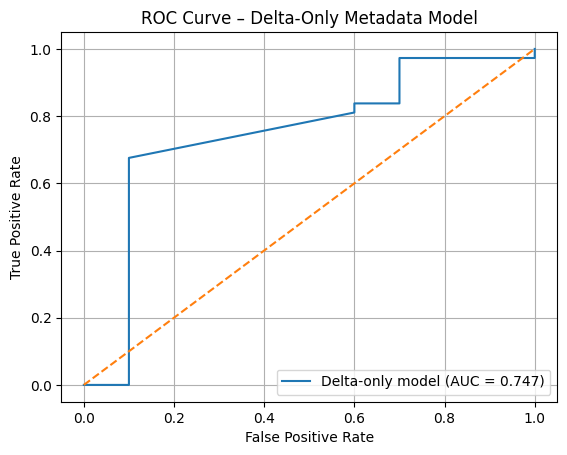

In [13]:
# Cell 17 – ROC curve for the full delta-only model

import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"Delta-only model (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Delta-Only Metadata Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## 5. Coefficient-based feature selection (delta features)

The logistic regression model assigns one coefficient to each delta feature.

- A positive coefficient indicates that larger positive deltas (or ratios > 1)
  are associated with malicious versions.
- A negative coefficient indicates that such changes are associated with
  benign versions.
- Large absolute values indicate strong influence on the prediction.

The next cells:

1. Extract and rank coefficients by their absolute value.
2. Group delta features into:
   - Registry-derived deltas (size and entropy-like).
   - Other deltas (e.g., dependency deltas from previous notebook).
3. Select high-impact features from each group and train a compact model
   still restricted to delta-only inputs.


In [14]:
# Cell 19 – Extract coefficients and rank delta features by absolute value

clf: LogisticRegression = pipe.named_steps["clf"]

coefs = clf.coef_.ravel()
feature_importance = (
    pd.DataFrame(
        {
            "feature": delta_feature_cols,
            "coef": coefs,
            "coef_abs": np.abs(coefs),
        }
    )
    .sort_values("coef_abs", ascending=False)
    .reset_index(drop=True)
)

print("Top 25 delta features by |coefficient|:")
feature_importance.head(25)


Top 25 delta features by |coefficient|:


,feature,coef,coef_abs
0,delta_num_keywords,1.478283,1.478283
1,ratio_npm_file_count,-1.379576,1.379576
2,delta_num_dev_dependencies,-1.173990,1.173990
3,delta_version_num_dots,1.140475,1.140475
4,delta_num_dependencies,0.521713,0.521713
5,delta_version_has_prerelease,-0.483729,0.483729
6,delta_num_scripts,0.426773,0.426773
7,delta_entropy_ratio_size,0.408852,0.408852
8,delta_npm_unpacked_size_bytes,0.172399,0.172399
9,delta_static_size_uncompressed_bytes,0.172399,0.172399


In [15]:
# Cell 20 – Group delta features into registry-derived vs other

REGISTRY_DELTA_PREFIXES = [
    "delta_static_",
    "ratio_static_",
    "delta_pypi_",
    "ratio_pypi_",
    "delta_npm_",
    "ratio_npm_",
    "delta_entropy_",
    "ratio_entropy_",
]

REGISTRY_DELTA_EXPLICIT = [
    "static_size_delta_vs_prev",
    "static_size_ratio_vs_prev",
]

def classify_delta_feature(name: str) -> str:
    if name in REGISTRY_DELTA_EXPLICIT:
        return "registry_delta"
    if any(name.startswith(p) for p in REGISTRY_DELTA_PREFIXES):
        return "registry_delta"
    return "other_delta"


feature_importance["group"] = feature_importance["feature"].apply(
    classify_delta_feature
)

print("Top 15 registry-derived delta features by |coef|:")
feature_importance[feature_importance["group"] == "registry_delta"].head(15)


Top 15 registry-derived delta features by |coef|:


,feature,coef,coef_abs,group
1,ratio_npm_file_count,-1.379576,1.379576,registry_delta
7,delta_entropy_ratio_size,0.408852,0.408852,registry_delta
8,delta_npm_unpacked_size_bytes,0.172399,0.172399,registry_delta
9,delta_static_size_uncompressed_bytes,0.172399,0.172399,registry_delta
10,static_size_delta_vs_prev,0.172399,0.172399,registry_delta
12,ratio_static_size_uncompressed_bytes,0.045041,0.045041,registry_delta
13,ratio_npm_unpacked_size_bytes,0.045041,0.045041,registry_delta
14,static_size_ratio_vs_prev,0.045041,0.045041,registry_delta
15,delta_npm_file_count,-0.044339,0.044339,registry_delta
16,ratio_entropy_ratio_size,0.043215,0.043215,registry_delta


In [16]:
# Cell 21 – Select a compact delta-only feature set

TOP_K_REGISTRY = 10
TOP_K_OTHER = 10

top_registry = (
    feature_importance[feature_importance["group"] == "registry_delta"]
    .head(TOP_K_REGISTRY)["feature"]
    .tolist()
)

top_other = (
    feature_importance[feature_importance["group"] == "other_delta"]
    .head(TOP_K_OTHER)["feature"]
    .tolist()
)

selected_compact_features = sorted(set(top_registry + top_other))

print("Selected registry-derived delta features:")
for f in top_registry:
    print(" -", f)

print("\nSelected other delta features:")
for f in top_other:
    print(" -", f)

print(f"\nTotal compact delta-only feature count: {len(selected_compact_features)}")


Selected registry-derived delta features:
 - ratio_npm_file_count
 - delta_entropy_ratio_size
 - delta_npm_unpacked_size_bytes
 - delta_static_size_uncompressed_bytes
 - static_size_delta_vs_prev
 - ratio_static_size_uncompressed_bytes
 - ratio_npm_unpacked_size_bytes
 - static_size_ratio_vs_prev
 - delta_npm_file_count
 - ratio_entropy_ratio_size

Selected other delta features:
 - delta_num_keywords
 - delta_num_dev_dependencies
 - delta_version_num_dots
 - delta_num_dependencies
 - delta_version_has_prerelease
 - delta_num_scripts
 - delta_description_len
 - delta_version_len
 - delta_has_license
 - delta_num_requires_dist

Total compact delta-only feature count: 20


In [17]:
# Cell 22 – Train and evaluate a compact delta-only model

X2 = enriched[selected_compact_features].fillna(0.0).astype(float)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=0.3, random_state=42, stratify=y
)

pipe2 = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=-1,
    )),
])

pipe2.fit(X2_train, y2_train)

y2_proba = pipe2.predict_proba(X2_test)[:, 1]
y2_pred = pipe2.predict(X2_test)

auc2 = roc_auc_score(y2_test, y2_proba)
print(f"Compact delta-only model ROC AUC: {auc2:.3f}\n")

print("Classification report – compact delta-only model:")
print(classification_report(y2_test, y2_pred, digits=3))


Compact delta-only model ROC AUC: 0.743

Classification report – compact delta-only model:
              precision    recall  f1-score   support

           0      0.346     0.900     0.500        10
           1      0.952     0.541     0.690        37

    accuracy                          0.617        47
   macro avg      0.649     0.720     0.595        47
weighted avg      0.823     0.617     0.649        47



## 6. Summary of delta-only registry feature extraction and modeling

This notebook performs registry-based feature extraction and constructs
a **delta-only** feature set for version-level package classification.

Key points:

- Static registry information (PyPI/npm) is used to derive:
  - Unified package sizes (compressed/uncompressed).
  - Per-version density/entropy-like indicators (bytes-per-file).

- These static attributes are converted into **delta features**:
  - Unified size:
    - `static_size_delta_vs_prev`, `static_size_ratio_vs_prev`.
  - Registry-derived attributes:
    - `delta_<feature>` and `ratio_<feature>` for:
      - `static_size_compressed_bytes`
      - `static_size_uncompressed_bytes`
      - `pypi_size_bytes`
      - `npm_unpacked_size_bytes`
      - `npm_file_count`
      - `entropy_ratio_size`
      - `entropy_indicator`

- The model is trained exclusively on:
  - Existing delta features from the previous notebook (`delta_cols`).
  - New registry-derived delta features.
  - Unified size delta features.

- Two logistic regression models are evaluated:
  - A full delta-only model over all delta features.
  - A compact delta-only model using high-impact registry and other delta
    features identified by coefficient magnitude.

This demonstrates how **changes between versions**, rather than static
absolute values, can be used to detect potentially malicious package
versions in npm and PyPI ecosystems.


In [18]:
# Optional – Sanity checks on delta-only feature matrix

print("Total delta features in model:", len(delta_feature_cols))

print("\nFirst 40 delta features:")
for f in delta_feature_cols[:40]:
    print(" -", f)

# Count how many come from registry-derived deltas vs other deltas
registry_like = [f for f in delta_feature_cols if (
    f.startswith("delta_static_")
    or f.startswith("ratio_static_")
    or f.startswith("delta_pypi_")
    or f.startswith("ratio_pypi_")
    or f.startswith("delta_npm_")
    or f.startswith("ratio_npm_")
    or f.startswith("delta_entropy_")
    or f.startswith("ratio_entropy_")
    or f in ["static_size_delta_vs_prev", "static_size_ratio_vs_prev"]
)]
other_like = [f for f in delta_feature_cols if f not in registry_like]

print(f"\nRegistry-derived delta features: {len(registry_like)}")
print(f"Other delta features (e.g., from previous notebook): {len(other_like)}")

print("\nSample rows from X (delta-only features):")
X.head()


Total delta features in model: 29

First 40 delta features:
 - delta_description_len
 - delta_entropy_indicator
 - delta_entropy_ratio_size
 - delta_has_author
 - delta_has_license
 - delta_npm_file_count
 - delta_npm_unpacked_size_bytes
 - delta_num_classifiers
 - delta_num_dependencies
 - delta_num_dev_dependencies
 - delta_num_keywords
 - delta_num_requires_dist
 - delta_num_scripts
 - delta_pypi_size_bytes
 - delta_static_size_compressed_bytes
 - delta_static_size_uncompressed_bytes
 - delta_summary_len
 - delta_version_has_prerelease
 - delta_version_len
 - delta_version_num_dots
 - ratio_entropy_indicator
 - ratio_entropy_ratio_size
 - ratio_npm_file_count
 - ratio_npm_unpacked_size_bytes
 - ratio_pypi_size_bytes
 - ratio_static_size_compressed_bytes
 - ratio_static_size_uncompressed_bytes
 - static_size_delta_vs_prev
 - static_size_ratio_vs_prev

Registry-derived delta features: 16
Other delta features (e.g., from previous notebook): 13

Sample rows from X (delta-only features):

,delta_description_len,delta_entropy_indicator,delta_entropy_ratio_size,delta_has_author,delta_has_license,delta_npm_file_count,delta_npm_unpacked_size_bytes,delta_num_classifiers,delta_num_dependencies,delta_num_dev_dependencies,...,delta_version_num_dots,ratio_entropy_indicator,ratio_entropy_ratio_size,ratio_npm_file_count,ratio_npm_unpacked_size_bytes,ratio_pypi_size_bytes,ratio_static_size_compressed_bytes,ratio_static_size_uncompressed_bytes,static_size_delta_vs_prev,static_size_ratio_vs_prev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Delta Feature Semantics (Delta-Only Feature Matrix)

The final model is trained exclusively on **delta features**, i.e., how each version of a package changes relative to its immediate predecessor.  
The feature matrix contains 29 numeric columns, all of which are either absolute differences (`delta_…`) or ratios (`ratio_…`), plus unified size deltas.

---

#### 1. Text and Metadata Deltas

These features capture how descriptive metadata and basic fields evolve between versions.

- `delta_description_len`  
  Change in the length of the long description (in characters).

- `delta_summary_len`  
  Change in the length of the short summary field.

- `delta_has_author`  
  Change in an indicator flag for whether an author is specified  
  (values are typically 0, 1, or −1 when the presence of the field changes).

- `delta_has_license`  
  Change in an indicator flag for whether a license field is present.

- `delta_num_classifiers`  
  Change in the number of PyPI classifiers assigned to the project.

- `delta_num_keywords`  
  Change in the number of keywords or tags associated with the project.

- `delta_version_len`  
  Change in the length of the version string.

- `delta_version_num_dots`  
  Change in the number of dot separators in the version string  
  (e.g., moving from `1.2.3` to `2.0`).

- `delta_version_has_prerelease`  
  Change in a prerelease indicator flag (e.g., transition into or out of versions
  like `1.0.0-beta`).

These features capture structural and semantic shifts in project metadata and versioning practices.

---

#### 2. Dependency Graph Deltas

These features describe how the dependency surface of a project changes over time.

- `delta_num_dependencies`  
  Change in the number of runtime dependencies.

- `delta_num_dev_dependencies`  
  Change in the number of development dependencies.

- `delta_num_requires_dist`  
  Change in the number of `requires_dist` entries on PyPI.

- `delta_num_scripts`  
  Change in the number of npm scripts defined in `package.json`.

Large positive deltas in these fields indicate expansion of the dependency graph
or additional install-time behavior, while negative values indicate simplification.

---

#### 3. Registry Size and Structure Deltas

These features track how the package artifact itself grows or shrinks between releases.

- `delta_pypi_size_bytes`  
  Difference in the main PyPI distribution size between the current and previous version.

- `delta_static_size_compressed_bytes`  
  Change in the compressed size used in the unified size calculation.

- `delta_static_size_uncompressed_bytes`  
  Change in the uncompressed size used in the unified size calculation (where available).

- `delta_npm_unpacked_size_bytes`  
  Change in the uncompressed npm tarball size (in bytes).

- `delta_npm_file_count`  
  Change in the number of files contained in the npm package.

- `static_size_delta_vs_prev`  
  Unified size difference between current and previous version; this is the main
  size delta feature.

- `static_size_ratio_vs_prev`  
  Ratio of the unified size of the current version to that of the previous version.

These features highlight unusual growth or shrinkage in the package artifact.  
For example, a large positive `static_size_delta_vs_prev` combined with a large
increase in `delta_num_dependencies` indicates a version that suddenly becomes
larger and more complex than its predecessor.

---

#### 4. Entropy-Like / Density Deltas

These features use simple size-per-file measures as proxies for bundling or packing behavior,
derived purely from registry metadata.

- `entropy_ratio_size`  
  Bytes per file for the current version, computed as  
  `static_pkg_size_bytes / npm_file_count` when both quantities are available.

- `entropy_indicator`  
  Binary flag derived from `entropy_ratio_size` using a threshold; high values
  indicate unusually dense (large bytes-per-file) layouts.

- `delta_entropy_ratio_size`  
  Change in bytes-per-file between current and previous version.

- `ratio_entropy_ratio_size`  
  Proportional change in bytes-per-file (ratio of current to previous).

- `delta_entropy_indicator`  
  Change in the density indicator (e.g., transition from low-density to high-density layout).

- `ratio_entropy_indicator`  
  Ratio-style change for the density indicator (where applicable).

Sudden increases in these density features can correspond to heavy minification,
bundling, or the introduction of large opaque blobs into the package.

---

#### 5. Ratio Features for Scale-Invariant Change

For several size-related attributes, both deltas and ratios are included.

Examples:

- `ratio_npm_unpacked_size_bytes`  
- `ratio_npm_file_count`  
- `ratio_pypi_size_bytes`  
- `ratio_static_size_compressed_bytes`  
- `ratio_static_size_uncompressed_bytes`  
- `ratio_entropy_ratio_size`  
- `ratio_entropy_indicator`  

Values close to 1.0 (e.g., `0.9996`–`1.0001`) correspond to minor adjustments,
while ratios significantly above or below 1 indicate large relative changes,
even if the absolute size of the project is small.

---

### Interpretation of Example Rows

A typical row in the delta matrix might show:

- `delta_npm_unpacked_size_bytes = -91` and `static_size_delta_vs_prev = -91.0`  
  → The package becomes 91 bytes smaller in this release, and the unified size confirms the same.

- `ratio_npm_unpacked_size_bytes ≈ 0.9996` and `static_size_ratio_vs_prev ≈ 0.9996`  
  → The relative change is small; the package size is effectively stable.

- `delta_version_num_dots = -1`  
  → The new version string has one fewer dot than the previous one  
    (e.g., `1.2.3` → `2.0`), signalling a structural change in versioning.

- `delta_entropy_ratio_size` slightly negative, `ratio_entropy_ratio_size ≈ 0.9996`  
  → Bytes-per-file decreased slightly, indicating a marginal reduction in density.

Overall, the model does not rely on static absolute values, but on **how each
release diverges from its immediate predecessor** in terms of size, density,
dependencies, and metadata. This delta-only design emphasizes anomalous
changes that may signal malicious behavior hidden within otherwise legitimate
projects.
